<a href="https://colab.research.google.com/github/romiaprilian7406/sisi-gelap-dunia-saham-sentiment-analysis/blob/romiaprilian7406-patch-9/notebooks/sisi_gelap_dunia_saham_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install emoji -q

# Import Library

In [ ]:
import re
import emoji
import torch
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import random
import joblib
import warnings

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
from torch.nn.functional import softmax
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Global Configuration

In [ ]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Hardware Acceleration: {device.upper()}")
if device == 'cpu':
    print("Warning: Disarankan menggunakan T4 GPU.")

Hardware Acceleration: CUDA


# Data Loading

In [ ]:
def load_data(url):
    try:
        df = pd.read_csv(url)

        print(f"Berhasil connect dan mengambil dataset: {url}")
        return df

    except Exception as e:
        print(f"Error Loading Data: {e}")
        return pd.DataFrame()

DATASET_URL = "https://raw.githubusercontent.com/romiaprilian7406/sisi-gelap-dunia-saham-sentiment-analysis/refs/heads/main/data/sisi_gelap_dunia_saham_comments.csv"

df_raw = load_data(DATASET_URL)

Berhasil connect dan mengambil dataset: https://raw.githubusercontent.com/romiaprilian7406/sisi-gelap-dunia-saham-sentiment-analysis/refs/heads/main/data/sisi_gelap_dunia_saham_comments.csv


# Data Integrity Cleaning

In [ ]:
# Membersihkan integritas data: Hapus Null dan Duplikat
def clean_data_integrity(df):
    initial_len = len(df)

    # 1. Hapus Baris Kosong (NaN di kolom text)
    df_clean = df.dropna(subset=['text']).copy()
    nan_count = initial_len - len(df_clean)

    # 2. Hapus Duplikat (Berdasarkan isi komentar yang sama persis)
    # Penting untuk sentimen analisis agar model tidak bias ke komentar spam
    df_clean.drop_duplicates(subset=['text'], keep='first', inplace=True)
    dup_count = initial_len - nan_count - len(df_clean)

    print(f"Original Rows : {initial_len}")
    print(f"Removed (NaN) : {nan_count}")
    print(f"Removed (Dup) : {dup_count}")
    print(f"Final Rows    : {len(df_clean)}")

    return df_clean

df = clean_data_integrity(df_raw)

Original Rows : 1018
Removed (NaN) : 0
Removed (Dup) : 3
Final Rows    : 1015


# Text Preprocessing

In [ ]:
# Pipeline: Lowercase -> Hapus URL/Mention -> Hapus Emoji -> Bersihkan Karakter Aneh
def clean_financial_text_simple(text):
    # 1. Case Folding (Huruf kecil semua)
    text = str(text).lower()

    # 2. Hapus Entity (Mention & URL)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text) # Hapus @username
    text = re.sub(r'http\S+', '', text)        # Hapus link/URL

    # 3. Hapus Emoji
    text = emoji.replace_emoji(text, replace='')

    # 4. Hapus Karakter Non-Alphanumeric
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)

    # 5. Hapus huruf berulang (e.g., "bangeeet" -> "banget")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 6. Whitespace cleaning (Hapus spasi ganda)
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Terapkan fungsi ke kolom text
df['clean_text'] = df['text'].apply(clean_financial_text_simple)

# Filter: Hapus teks yang menjadi terlalu pendek/kosong setelah cleaning
df_clean = df[df['clean_text'].str.len() > 3].copy()

print(f"Sebelum Preprocessing : {len(df)}")
print(f"Setelah Preprocessing : {len(df_clean)}")
print(f"Dibuang : {len(df) - len(df_clean)}")

print("\nPreview Data:")
display(df_clean[['text', 'clean_text']].head())

Sebelum Preprocessing : 1015
Setelah Preprocessing : 988
Dibuang : 27

Preview Data:


,text,clean_text
0,Gabung ke Komunitas Akademi Crypto: https://di...,gabung ke komunitas akademi crypto
2,Lagi nyelem ya bang😅,lagi nyelem ya bang
3,rewatch ygy 😹😹,rewatch ygy
5,"2 vidio tentang saham daging semua,",2 vidio tentang saham daging semua
6,saham itu titik kumpul orang yang rugi dan unt...,saham itu titik kumpul orang yang rugi dan unt...


# Feature Extraction (RoBERTa)

In [ ]:
# Hybrid Feature Extraction (RoBERTa)

# Setup Model Transformer
MODEL_NAME = "w11wo/indonesian-roberta-base-sentiment-classifier"

print(f"Transformer: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model_classifier = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME).to(device)
model_base = AutoModel.from_pretrained(MODEL_NAME).to(device)

# Fungsi Hybrid: Generate Pseudo-Labels & Extract Embeddings
def extract_features_and_labels(texts: list, batch_size: int = 32):
    all_labels = []
    all_embeddings = []

    model_classifier.eval()
    model_base.eval()

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting Features"):
            batch_texts = texts[i:i+batch_size]

            # Tokenisasi
            inputs = tokenizer(batch_texts, padding=True, truncation=True,
                             max_length=128, return_tensors="pt").to(device)

            # A. Pseudo-Labeling
            logits = model_classifier(**inputs).logits
            preds = torch.argmax(softmax(logits, dim=1), dim=1).cpu().numpy()
            labels = [model_classifier.config.id2label[p] for p in preds]
            all_labels.extend(labels)

            # B. Feature Extraction
            outputs = model_base(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embeddings)

            # Bersihkan VRAM GPU per batch
            del inputs, outputs
            torch.cuda.empty_cache()

    return all_labels, np.vstack(all_embeddings)

texts_list = df_clean['clean_text'].tolist()
pseudo_labels, X_embeddings = extract_features_and_labels(texts_list)

df_clean['sentiment_label'] = pseudo_labels
df_clean['sentiment_label'] = df_clean['sentiment_label'].astype(str).str.title()

print(f"Shape: {X_embeddings.shape}")

Transformer: w11wo/indonesian-roberta-base-sentiment-classifier


Some weights of RobertaModel were not initialized from the model checkpoint at w11wo/indonesian-roberta-base-sentiment-classifier and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Extracting Features:   0%|          | 0/31 [00:00<?, ?it/s]

Shape: (988, 768)


# Sentiment Labeled Distribution

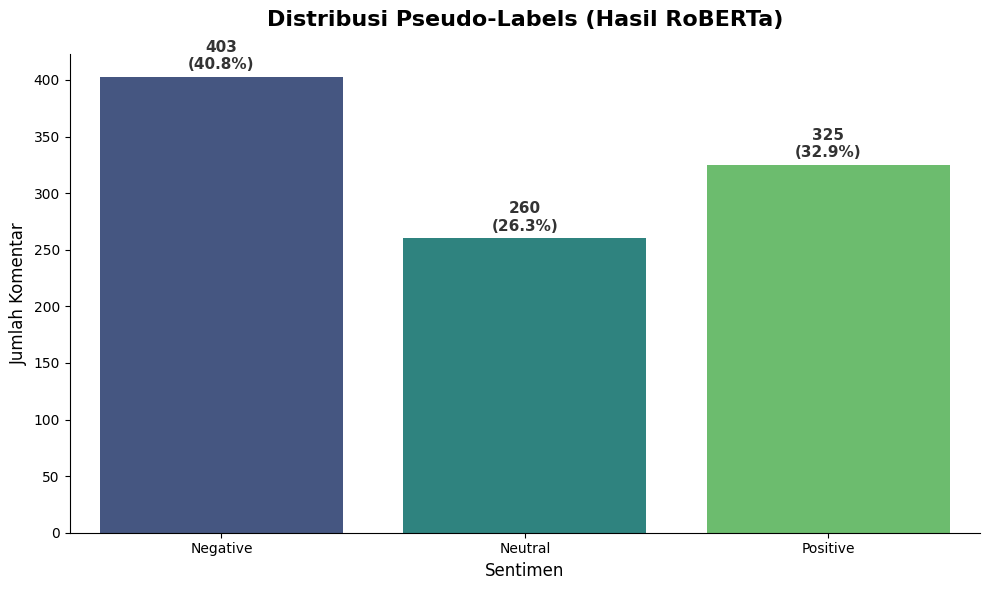

In [ ]:
# Distribusi sentimen
def plot_sentiment_distribution(df):
    plt.figure(figsize=(10, 6))

    # Hitung total data
    total = len(df)

    # Urutan logis: Negatif -> Netral -> Positif
    order_list = ['Negative', 'Neutral', 'Positive']

    # Plot Bar Chart
    ax = sns.countplot(x='sentiment_label', data=df,
                       palette='viridis', order=order_list)

    plt.title("Distribusi Pseudo-Labels (Hasil RoBERTa)", fontsize=16, fontweight='bold', pad=20)
    plt.xlabel("Sentimen", fontsize=12)
    plt.ylabel("Jumlah Komentar", fontsize=12)

    # Tambahkan Anotasi (Jumlah & Persentase)
    for p in ax.patches:
        count = int(p.get_height())
        if total > 0:
            percentage = (count / total) * 100
        else:
            percentage = 0

        label_text = f"{count}\n({percentage:.1f}%)"

        ax.annotate(label_text,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 15), textcoords = 'offset points',
                    fontsize=11, fontweight='bold', color='#333333')

    sns.despine()
    plt.tight_layout()
    plt.show()

plot_sentiment_distribution(df_clean)

# Export Labeled Data

In [ ]:
# Menyimpan dataset yang sudah diberi label oleh RoBERTa ke file CSV
def export_labeled_data(df):
    FILENAME = "sgds_labeled.csv"

    try:
        # Simpan teks asli, teks bersih, dan labelnya
        export_cols = ['text', 'clean_text', 'sentiment_label']

        # Validasi kolom sebelum export (Hanya simpan yang ada)
        valid_cols = [col for col in export_cols if col in df.columns]

        # Export ke CSV
        df[valid_cols].to_csv(FILENAME, index=False, encoding='utf-8')

        print(f"File data yang telah diberi label: {FILENAME}")

    except Exception as e:
        print(f"Gagal menyimpan file: {e}")

export_labeled_data(df_clean)

File data yang telah diberi label: sgds_labeled.csv


# Modeling

In [ ]:
# 1. Encoding Label (String 'Positive' -> Angka 0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(df_clean['sentiment_label'])

# 2. Split Data
# Stratify=y_encoded memastikan proporsi sentimen seimbang di train & test
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# 3. Konfigurasi XGBoost (Optimized for Embeddings)
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',
    num_class=len(le.classes_),
    device=device,
    tree_method="hist",
    random_state=42
)

# 4. Training Process
xgb_clf.fit(X_train, y_train)

# 5. Prediction on Test Set
y_pred = xgb_clf.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred)
y_test_labels = le.inverse_transform(y_test)

# Model Evaluation

Evaluation Report
Final Accuracy: 97.47%

Detailed Metrics:
              precision    recall  f1-score   support

    Negative       0.98      0.99      0.98        81
     Neutral       0.96      0.96      0.96        52
    Positive       0.98      0.97      0.98        65

    accuracy                           0.97       198
   macro avg       0.97      0.97      0.97       198
weighted avg       0.97      0.97      0.97       198



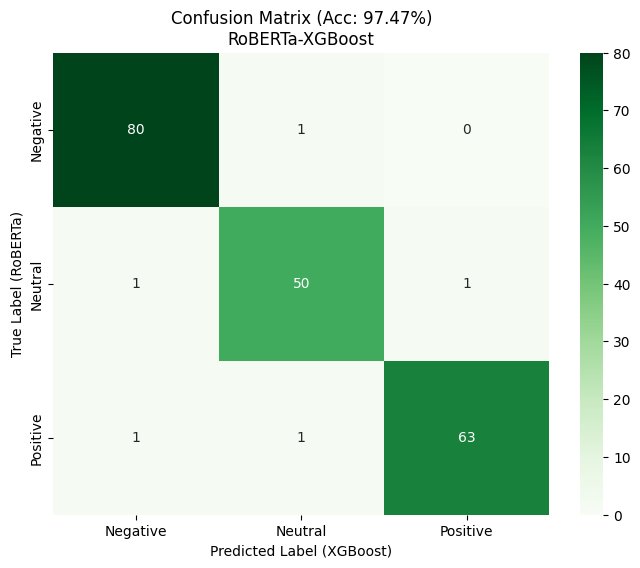

In [ ]:
print("Evaluation Report")

# 1. Accuracy Score
acc = accuracy_score(y_test_labels, y_pred_labels)
print(f"Final Accuracy: {acc:.2%}")

# 2. Detailed Classification Report
print("\nDetailed Metrics:")
print(classification_report(y_test_labels, y_pred_labels))

# 3. Confusion Matrix Visualization
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix (Acc: {acc:.2%})\nRoBERTa-XGBoost')
plt.ylabel('True Label (RoBERTa)')
plt.xlabel('Predicted Label (XGBoost)')
plt.show()

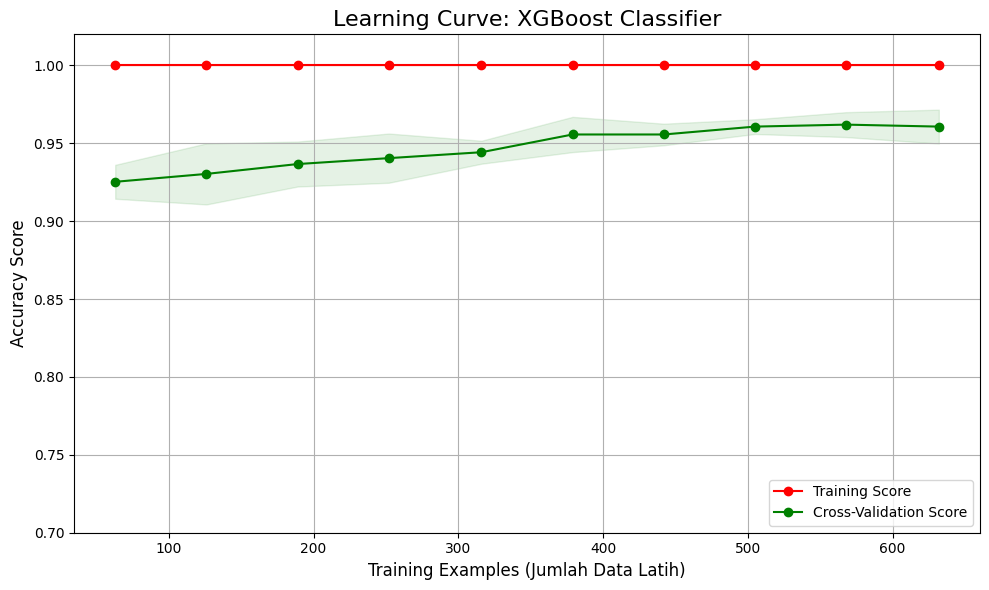

Training Accuracy (Final): 100.00%
Validation Accuracy (Final): 96.08%
Fitting Gap: 3.92%


In [ ]:
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    # Hitung Mean dan Std Deviasi
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plotting
    plt.figure(figsize=(10, 6))

    # Area Shading (Standar Deviasi)
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="g")

    # Garis Utama
    plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_mean, 'o-', color="g", label="Cross-Validation Score")

    plt.ylim(0.7, 1.02)

    # Dekorasi
    plt.title("Learning Curve: XGBoost Classifier", fontsize=16)
    plt.xlabel("Training Examples (Jumlah Data Latih)", fontsize=12)
    plt.ylabel("Accuracy Score", fontsize=12)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Analisis Otomatis Gap
    gap = train_mean[-1] - test_mean[-1]
    print(f"Training Accuracy (Final): {train_mean[-1]:.2%}")
    print(f"Validation Accuracy (Final): {test_mean[-1]:.2%}")
    print(f"Fitting Gap: {gap:.2%}")

plot_learning_curve(xgb_clf, X_train, y_train)

# Export Model

In [ ]:
# Model XGBoost (Classifier)
algo_model = 'sgds_xgboost_model.joblib'
joblib.dump(xgb_clf, algo_model)

# Label Encoder (Helper)
lencoder_model = 'sgds_label_encoder.joblib'
joblib.dump(le, lencoder_model)

print(f"Model XGBoost di ekspor sebagai: {algo_model}")
print(f"Model Label Encoder di ekspor sebagai: {lencoder_model}")

Model XGBoost di ekspor sebagai: sgds_xgboost_model.joblib
Model Label Encoder di ekspor sebagai: sgds_label_encoder.joblib
